# Symp2Doc : AI Powered Disease Prediction #  

## Introduction ##

Symp2Doc: AI Powered Disease Prediction is an innovative project that leverages natural language processing (NLP) to accurately predict diseases based on patient-reported symptoms. The project considers three advanced neural networks: Dense Neural Network (DNN) for fundamental classification tasks, Gated Recurrent Unit (GRU) for capturing temporal dependencies in symptom sequences, and Convolutional Neural Network (CNN) to effectively extract features from embedded symptom representations.

This project is built on a comprehensive dataset that includes a wide range of symptom-disease pairs, enabling the model to learn the intricate relationships between reported symptoms and their corresponding diseases. By training on this dataset, the system aims to provide healthcare professionals with a powerful tool for quick and reliable disease prediction based on natural language input from patients.

In [51]:
import numpy as np 
import pandas as pd
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import zipfile
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/wordnet-zip/wordnet/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
import nltk

# Append the extracted path to NLTK's data paths
nltk.data.path.append("/kaggle/input/wordzip-dir")

# Verify the path
print(nltk.data.path)


['/root/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/kaggle/input/wordzip-dir']


In [4]:
from nltk.corpus import wordnet as wn


# Example: Get synsets (synonyms) for the word 'happy'
synonyms = wn.synsets('happy')
print(synonyms)

[Synset('happy.a.01'), Synset('felicitous.s.02'), Synset('glad.s.02'), Synset('happy.s.04')]


In [5]:
for dirname, _, filenames in os.walk('/kaggle/input/symptom2disease'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        df = pd.read_csv(path)
        print(path)


/kaggle/input/symptom2disease/Symptom2Disease.csv


## Exploratory Data Analysis ##  

The below EDA steps not only provide insight into the dataset but also lays a strong foundation for model training and development. It also ensures that the neural networks effectively learn from relevant data.  

1.  Countplot of Diseases:
    * Created a countplot to visualize the distribution of diseases in the dataset.
    * Identified the most common diseases reported, helping to understand the data
      balance and prevalence of specific conditions.
2. Stratified Train-Test Split:
     * Implemented a stratified split of the dataset into training and testing sets to
       ensure that the proportion of each disease category is preserved in both sets.
     * This approach helps prevent class imbalance issues during model training and
       evaluation.
3. Stop Words Removal:
     * Performed stop words removal to eliminate common words that do not add
       significant meaning to the symptoms.
     * Specifically excluded critical stop words like "no" and "not," which provide
       important context in symptom descriptions.
4. Tokenization:
     * Tokenized the cleaned symptom texts to convert sentences into individual words or
       tokens, preparing the data for further processing.
     * This step helps in isolating each word for lemmatization and vector
       representation.
5. Lemmatization:
     * Applied lemmatization to reduce words to their base or root form, improving the
       consistency of the symptom descriptions.
6. Word Cloud Generation of Symptoms:
     * Generated a word cloud to visually represent the most frequently occurring
       symptoms in the dataset.

In [6]:
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [7]:
print("Longest text length is:\n",df.text.str.len().max())

Longest text length is:
 317


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1200 non-null   int64 
 1   label       1200 non-null   object
 2   text        1200 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.2+ KB


[Text(0.5, 1.0, 'Disease Distribution In Dataset')]

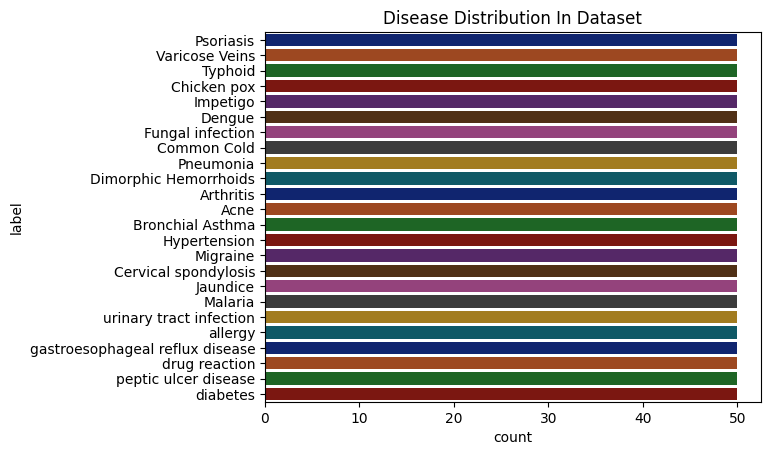

In [9]:
sns.countplot(y ='label', palette='dark', data = df).set(title="Disease Distribution In Dataset")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], 
                                                    test_size=0.2, stratify=df["label"] ,
                                                    random_state=42)


In [11]:
Disease_Train = pd.DataFrame().assign(Symptom=X_train, Diagnosis=y_train)
Disease_Train

,Symptom,Diagnosis
189,I'm feeling really nauseous and uneasy. I'm no...,Chicken pox
393,"I've been feeling awful, with a lot of congest...",Common Cold
386,I've been coughing a lot and finding it diffic...,Common Cold
462,I've been having a lot of problems using the r...,Dimorphic Hemorrhoids
1061,In addition to experiencing a change in taste ...,drug reaction
...,...,...
939,"My spirits have been incredibly low, and my pe...",urinary tract infection
3,"There is a silver like dusting on my skin, esp...",Psoriasis
712,I have been feeling hungry all the time and ha...,Migraine
323,A rash that appears to be developing throughou...,Fungal infection


[Text(0.5, 1.0, 'Disease Distribution In Training Dataset')]

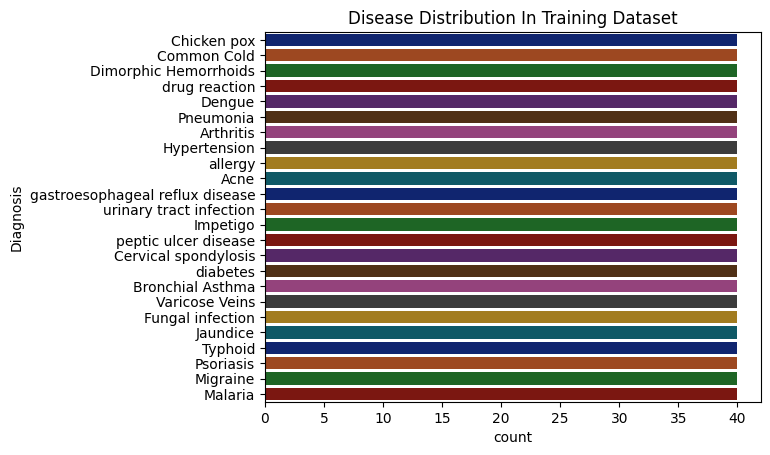

In [12]:
sns.countplot(y ='Diagnosis', palette='dark', data = Disease_Train).set(title="Disease Distribution In Training Dataset")

Some stop words carry contextual value. For example, in sentence classification, the difference between "I am fine" and "I am not fine" is critical, and removing "not" would change the meaning entirely. So we choose not to remove all the stopwords for this project.

In [13]:
# Load the default NLTK stopwords
default_stopwords = set(stopwords.words('english'))

# Create a list of stopwords to exclude
exclude_words = {'no', 'not', "but", "because", "during",
                'before', 'after', 'above', 'below', 'ain', 'aren', "aren't", 'couldn', 
                 "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 
                 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't" , 'wasn', "wasn't", 
                 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}

# Create a custom stopwords set by removing the excluded words
custom_stopwords = default_stopwords - exclude_words


In [14]:
lemmatizer = WordNetLemmatizer()

def tokenize_remove_stopwords_lemmatize(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in custom_stopwords]
    final = [lemmatizer.lemmatize(word) for word in filtered_words]
    return final
    #' '.join(filtered_words)


In [15]:
text = "My head is not feels well"
cleaned_text = tokenize_remove_stopwords_lemmatize(text)
print(cleaned_text) 

['head', 'not', 'feel', 'well']


In [16]:
Disease_Train['cleaned_symptom'] = Disease_Train['Symptom'].apply(tokenize_remove_stopwords_lemmatize)

Disease_Train

,Symptom,Diagnosis,cleaned_symptom
189,I'm feeling really nauseous and uneasy. I'm no...,Chicken pox,"[I'm, feeling, really, nauseous, uneasy., I'm,..."
393,"I've been feeling awful, with a lot of congest...",Common Cold,"[I've, feeling, awful,, lot, congestion, runny..."
386,I've been coughing a lot and finding it diffic...,Common Cold,"[I've, coughing, lot, finding, difficult, brea..."
462,I've been having a lot of problems using the r...,Dimorphic Hemorrhoids,"[I've, lot, problem, using, restroom, recently..."
1061,In addition to experiencing a change in taste ...,drug reaction,"[addition, experiencing, change, taste, fragra..."
...,...,...,...
939,"My spirits have been incredibly low, and my pe...",urinary tract infection,"[spirit, incredibly, low,, pee, smell, awful.,..."
3,"There is a silver like dusting on my skin, esp...",Psoriasis,"[silver, like, dusting, skin,, especially, low..."
712,I have been feeling hungry all the time and ha...,Migraine,"[feeling, hungry, time, sore, neck,, well, pro..."
323,A rash that appears to be developing throughou...,Fungal infection,"[rash, appears, developing, throughout, skin, ..."


In [17]:
X_test = X_test.apply(tokenize_remove_stopwords_lemmatize)
print(X_test)

408     [I've, experiencing, chills,, feel, really, ex...
856     [I've, intense, itching, body,, accompanied, c...
285     [feeling, extremely, tired, fatigued,, no, ene...
484     [I'm, lot, trouble, bowel, movement, lately., ...
543     [neck, tight, muscle, felt, quite, weak, recen...
                              ...                        
1194    [emotion, fluctuate,, hard, concentrate., mind...
186     [lost, appetite, completely, can't, seem, eat,...
467     [I've, constipated, really, hard, go, bathroom...
632     [must, confess, I've, experiencing, shortness,...
305     [Recently,, skin, quite, itchy,, rash, body., ...
Name: text, Length: 240, dtype: object


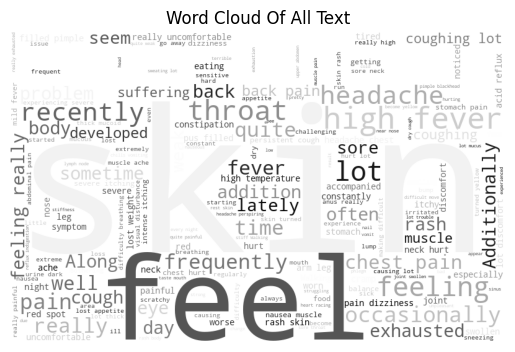

In [18]:
combined_text = ' '.join(Disease_Train['cleaned_symptom'].sum())

wc = WordCloud(background_color='white', colormap = 'binary', width = 800, 
               height = 500).generate(combined_text)
plt.axis('off')
plt.title('Word Cloud Of All Text')
plt.imshow(wc)

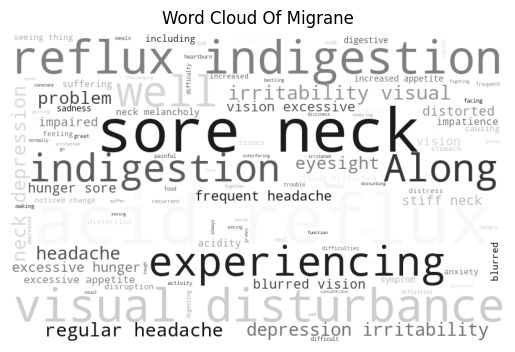

In [19]:
combined_text_Migraine = ' '.join(Disease_Train.loc[Disease_Train['Diagnosis']=='Migraine','cleaned_symptom'].sum())

wc_Migraine = WordCloud(background_color='white', colormap = 'binary', width = 800, 
               height = 500).generate(combined_text_Migraine)
plt.axis('off')
plt.title('Word Cloud Of Migrane')
plt.imshow(wc_Migraine)

## Convert Symptoms to Sentence Vectors Using GloVe ##  

We begin by loading pre-trained GloVe embeddings, which are dense vector representations of words capturing their semantic meanings based on context. The load_glove_model() function reads the GloVe file and stores the word vectors in a dictionary, allowing efficient access during the vectorization process. To convert individual symptoms into numerical representations, we use the words_to_vector() function, which takes a list of tokenized words as input. This function retrieves the corresponding GloVe vectors for each word, averages them, and returns a single vector that represents the entire symptom. This sentence vector serves as input for the neural network models, enabling them to process and understand the context of the symptoms effectively.

In [20]:
def load_glove_model(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_model("/kaggle/input/glove100d/glove.6B.100d.txt")

In [21]:
def words_to_vector(words, glove_embeddings, dim=100):
    vectors = [glove_embeddings.get(w, np.zeros(dim)) for w in words]
    return np.mean(vectors, axis=0)

In [22]:
X_train = np.array([words_to_vector(symptom, glove_embeddings) 
                    for symptom in Disease_Train['cleaned_symptom']])

X_test = np.array([words_to_vector(symptom, glove_embeddings) 
                   for symptom in X_test])

In [23]:
X_train

array([[ 0.00549676,  0.18684047,  0.31240381, ..., -0.19901067,
         0.09547052,  0.16912433],
       [-0.00117752,  0.08426309,  0.22544933, ..., -0.23873534,
         0.22535667,  0.00226095],
       [ 0.04500757,  0.12554348,  0.25093133, ..., -0.06884776,
         0.14825322,  0.10987271],
       ...,
       [-0.0748255 ,  0.31053187,  0.55610112, ..., -0.1077035 ,
         0.1811925 ,  0.20012387],
       [-0.2588475 ,  0.09768167,  0.0714386 , ..., -0.18834345,
         0.35312805, -0.08304268],
       [ 0.03148847,  0.13096233,  0.2921186 , ..., -0.17161053,
         0.29866467, -0.05885233]])

## Encode Disease Labels ##  

Next, we transform the categorical disease labels into a numerical format using a label encoder. This process assigns a unique integer to each disease, allowing the neural network to interpret the labels effectively during training. By converting the labels into a numerical representation, we ensure compatibility with the model's output layer, which uses softmax activation for multi-class classification.

In [24]:
encoder = LabelEncoder()

# Fit encoder on the training labels (y_train) only
y_train = encoder.fit_transform(Disease_Train['Diagnosis'])
y_test = encoder.transform(y_test)

print(encoder.classes_)

['Acne' 'Arthritis' 'Bronchial Asthma' 'Cervical spondylosis'
 'Chicken pox' 'Common Cold' 'Dengue' 'Dimorphic Hemorrhoids'
 'Fungal infection' 'Hypertension' 'Impetigo' 'Jaundice' 'Malaria'
 'Migraine' 'Pneumonia' 'Psoriasis' 'Typhoid' 'Varicose Veins' 'allergy'
 'diabetes' 'drug reaction' 'gastroesophageal reflux disease'
 'peptic ulcer disease' 'urinary tract infection']


In [25]:
y_train

array([ 4,  5,  5,  7, 20,  7,  6, 14,  1,  9, 18,  0,  9, 21, 23, 10, 22,
        3, 19,  2, 17,  8, 10,  6, 11,  7,  9,  4,  2, 14, 16, 11, 20, 20,
       19, 14,  3,  6,  7,  8,  5, 10, 14, 15,  3, 19, 11, 18,  6, 14,  1,
       21, 15, 11, 20, 16,  8, 13, 22,  1, 16,  7, 15, 11, 22,  2, 12,  1,
       22, 16,  2, 13, 17,  0, 21,  6, 16,  1, 19, 10,  7, 14, 21,  6, 22,
        2, 23,  1, 10, 18, 16, 13, 10, 12, 20,  8, 12, 23, 20, 14, 10, 13,
       21,  7,  1,  8, 23, 14, 16, 19,  3,  6, 11, 22,  9, 14, 13,  2, 12,
        6, 23,  5, 11, 11,  4,  5,  9, 17, 17, 16, 12,  4, 17,  6, 10, 17,
       17,  3,  5, 20,  8,  1, 22, 20,  8, 12,  0, 22,  8,  5,  5,  8, 18,
       15,  2,  0,  3, 12, 14, 20, 18,  0, 17,  0, 13, 10,  9,  1,  9, 17,
        6, 16,  4, 17, 13,  7,  7, 18, 11, 15, 20, 21, 12, 17, 17,  8,  2,
       21, 10, 10,  7,  9, 15, 22,  6, 15,  3, 14, 12, 12, 20,  0, 13, 10,
        8,  1, 23, 19, 13, 18, 18,  7, 23,  8, 22, 22, 13,  3, 15, 11,  6,
        7,  8, 19,  4, 22

## Build the Neural Network Model ##  

We will build 3 models for the purpose of this project and consider their performance and accuracy to decide on a final model.

#### Model 1 - Dense Layer ####  

The Dense Neural Network (DNN) is constructed using a sequential model, starting with an input layer that matches the size of the sentence vectors. The architecture includes multiple fully connected (dense) layers with activation functions such as ReLU to introduce non-linearity, followed by dropout layers to reduce overfitting. The final layer employs a softmax activation function to output probability distributions across the various disease classes, allowing for multi-class classification.

In [26]:
model_Dense = Sequential([Dense(128, activation='relu'),  # First Dense layer (input)
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(64, activation='relu'),  # Second Dense layer
    Dropout(0.3),  # Dropout with smaller rate
    Dense(32, activation='relu'),  # Third Dense layer
    Dense(24, activation='softmax')  # Output layer (10 classes)
])

In [27]:
model_Dense.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Model 2 - GRU Layer ####  

The Gated Recurrent Unit (GRU) model is designed to handle sequential data by incorporating GRU layers that capture temporal dependencies in the symptom sequences. The architecture starts with an input layer configured to accept 3D input, followed by one or more GRU layers with specified units, interspersed with dropout layers to mitigate overfitting. The final output layer is a dense layer with a softmax activation function, which provides the predicted probabilities for each disease class based on the learned temporal patterns from the input data.

In [28]:
X_train.shape

(960, 100)

In [29]:
X_test.shape

(240, 100)

In [30]:
X_train_reshaped = X_train.reshape(960, 20, 5)  # Shape (960, 30, 3)
X_test_reshaped = X_test.reshape(240, 20, 5)    # Shape (240, 30, 3)

In [31]:
model_GRU = Sequential([GRU(128, input_shape=(20, 5), return_sequences=True),
                       Dropout(0.5),
                       GRU(64, return_sequences=True),
                       Dropout(0.3),
                       GRU(32),
                       Dense(24, activation='softmax')
                       ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model_GRU.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Model 3 - Conv1D ####  

The Convolutional Neural Network (Conv1D) is structured to analyze the sequential nature of symptom data through convolutional layers. The model begins with a Conv1D layer that applies multiple filters across the input data to extract relevant features, followed by max pooling layers to down-sample the feature maps and reduce dimensionality. The architecture concludes with a flattening layer that transforms the pooled output into a 1D vector, followed by a dense output layer with softmax activation, allowing for classification of the input into different disease categories.

In [33]:
model_Conv1D = Sequential([Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(20,5)),
                           MaxPooling1D(pool_size=2),
                           Dropout(0.5),
                           Flatten(),
                           Dense(24, activation='softmax')
                       ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model_Conv1D.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Train The Model ##  

In the model training step, each neural network is trained using the preprocessed training dataset, where the model learns to map input symptom vectors to their corresponding disease labels. The training process involves adjusting the model's weights through backpropagation and optimization techniques, such as Adam to minimize the loss function, typically categorical cross-entropy for multi-class classification. During training, we also monitor performance metrics, such as accuracy, on both the training and validation datasets to ensure that the model generalizes well and avoids overfitting.

In [35]:
hist_Dense = model_Dense.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0330 - loss: 3.1941 - val_accuracy: 0.0208 - val_loss: 3.1601
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0537 - loss: 3.1552 - val_accuracy: 0.0729 - val_loss: 3.1343
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0633 - loss: 3.1262 - val_accuracy: 0.1771 - val_loss: 3.0841
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0763 - loss: 3.0796 - val_accuracy: 0.1667 - val_loss: 3.0101
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0954 - loss: 3.0328 - val_accuracy: 0.2083 - val_loss: 2.9137
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1270 - loss: 2.8989 - val_accuracy: 0.2812 - val_loss: 2.7912
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1906 - loss: 2.7760 - val_accuracy: 0.3125 - val_loss: 2.6601
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2512 - loss: 2.6225 - val_accuracy: 0.3333 - val_loss:

In [36]:

hist_GRU = model_GRU.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.0458 - loss: 3.1778 - val_accuracy: 0.0260 - val_loss: 3.1734
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0643 - loss: 3.1606 - val_accuracy: 0.0833 - val_loss: 3.1252
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0650 - loss: 3.0788 - val_accuracy: 0.0885 - val_loss: 3.0262
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0777 - loss: 2.9484 - val_accuracy: 0.1302 - val_loss: 2.9160
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1305 - loss: 2.8654 - val_accuracy: 0.0729 - val_loss: 2.9831
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1368 - loss: 2.8106 - val_accuracy: 0.1458 - val_loss: 2.8334
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1679 - loss: 2.7243 - val_accuracy: 0.1823 - val_loss: 2.8033
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1826 - loss: 2.6797 - val_accuracy: 0.1615 - v

In [37]:
y_train.shape

(960,)

In [38]:
X_train_reshaped.shape

(960, 20, 5)

In [39]:
hist_Conv1D = model_Conv1D.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0474 - loss: 3.1679 - val_accuracy: 0.1354 - val_loss: 3.1168
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1183 - loss: 3.0815 - val_accuracy: 0.1667 - val_loss: 3.0247
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2549 - loss: 2.9677 - val_accuracy: 0.2917 - val_loss: 2.9161
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3734 - loss: 2.8499 - val_accuracy: 0.5312 - val_loss: 2.7883
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5463 - loss: 2.6757 - val_accuracy: 0.6146 - val_loss: 2.6066
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5575 - loss: 2.5165 - val_accuracy: 0.5938 - val_loss: 2.4320
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5758 - loss: 2.3120 - val_accuracy: 0.5729 - val_loss: 2.2518
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5741 - loss: 2.1144 - val_accuracy: 0.6250 - val_loss

## Evaluate the Model ##  

In the model evaluation step, we assess the performance of each model on the test dataset using metrics like accuracy and a confusion matrix to analyze predictions. The Conv1D model achieved the highest accuracy, likely due to its ability to effectively capture local patterns in symptom data, while the GRU model performed the lowest, possibly because it struggled with the relatively short symptom sequences, making it harder to leverage its sequential learning capabilities fully.

In [40]:
loss_Dense, accuracy_Dense = model_Dense.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy_Dense * 100:.2f}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6509 - loss: 1.0841  
Test Accuracy: 66.25%


In [41]:
loss_GRU, accuracy_GRU = model_GRU.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {accuracy_GRU * 100:.2f}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3952 - loss: 2.0956
Test Accuracy: 42.08%


In [42]:
loss_Conv1D, accuracy_Conv1D = model_Conv1D.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {accuracy_Conv1D * 100:.2f}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7885 - loss: 0.9388  
Test Accuracy: 78.75%


In [43]:
# Model 1: Dense + Dropout
y_pred_model_Dense = model_Dense.predict(X_test)  # Shape: (240, 24)
y_pred_model_Dense_labels = np.argmax(y_pred_model_Dense, axis=1)  # Convert to class labels

# Model 2: GRU + Dropout + Dense
y_pred_model_GRU = model_GRU.predict(X_test_reshaped)  # Shape: (240, 24)
y_pred_model_GRU_labels = np.argmax(y_pred_model_GRU, axis=1)  # Convert to class labels

# Model 3: Conv1D + MaxPooling + Dropout + Dense
y_pred_model_Conv1D = model_Conv1D.predict(X_test_reshaped)  # Shape: (240, 24)
y_pred_model_Conv1D_labels = np.argmax(y_pred_model_Conv1D, axis=1)  # Convert to class labels


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [44]:
Diseases = list(encoder.classes_)

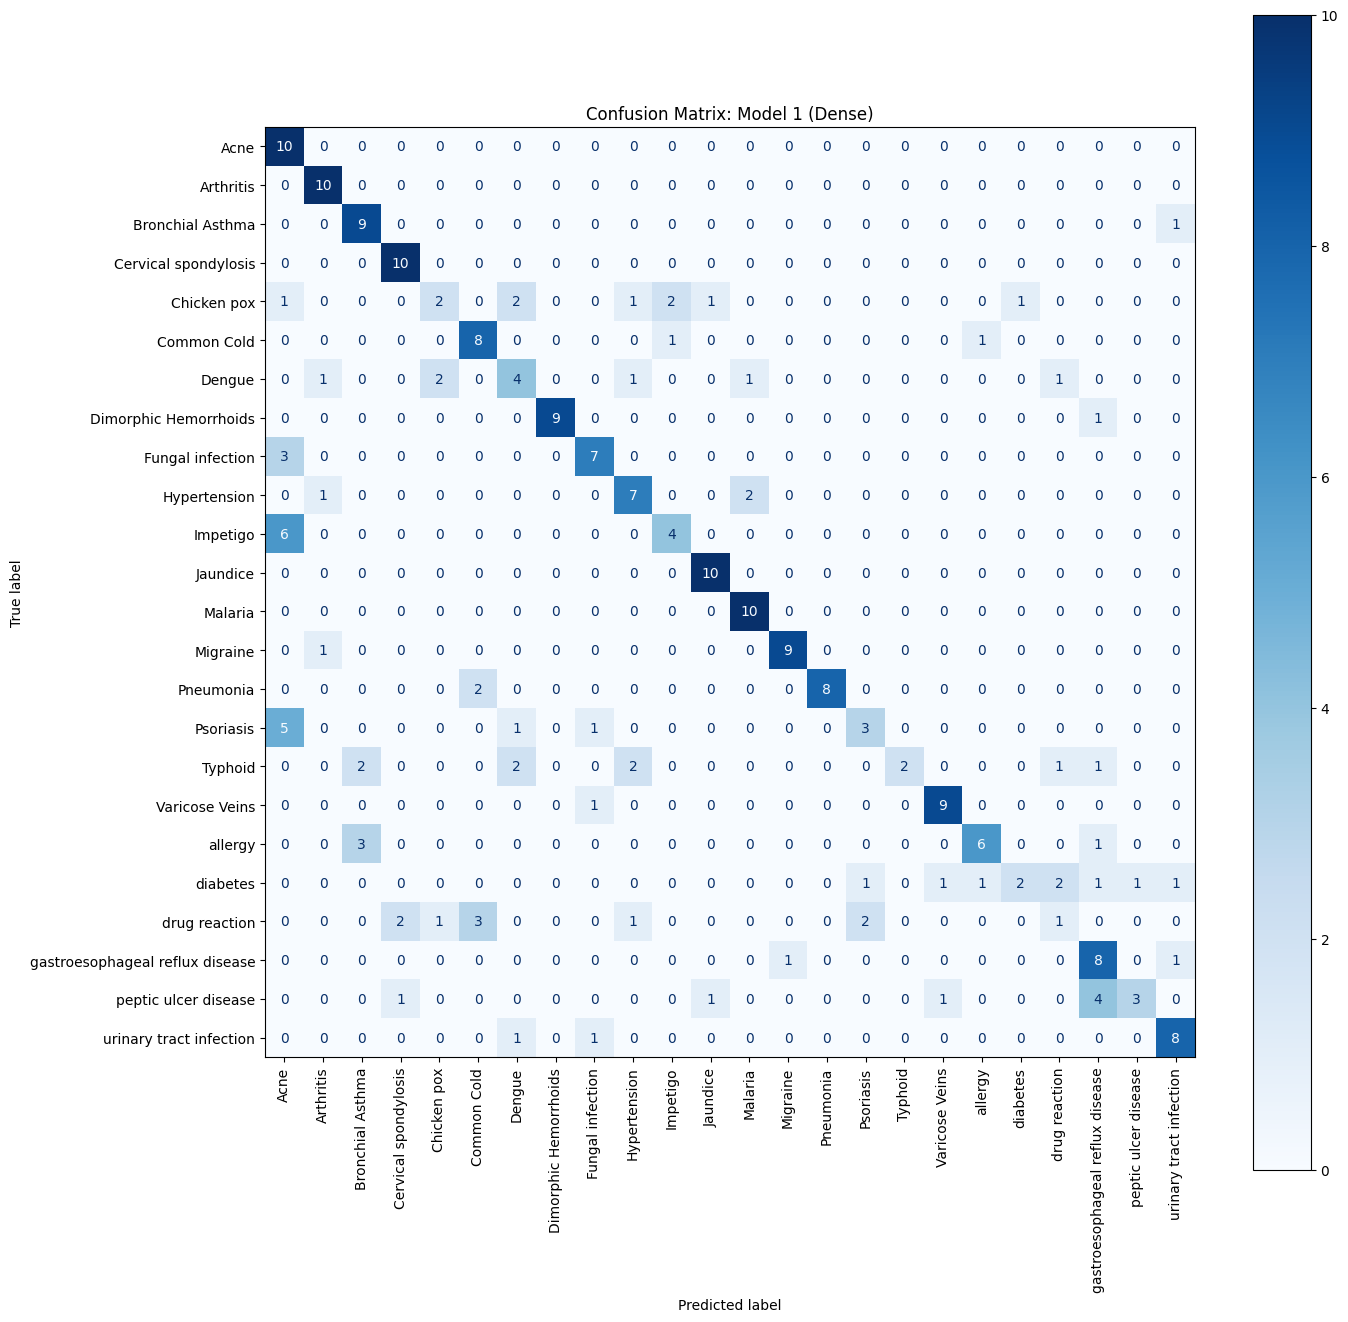

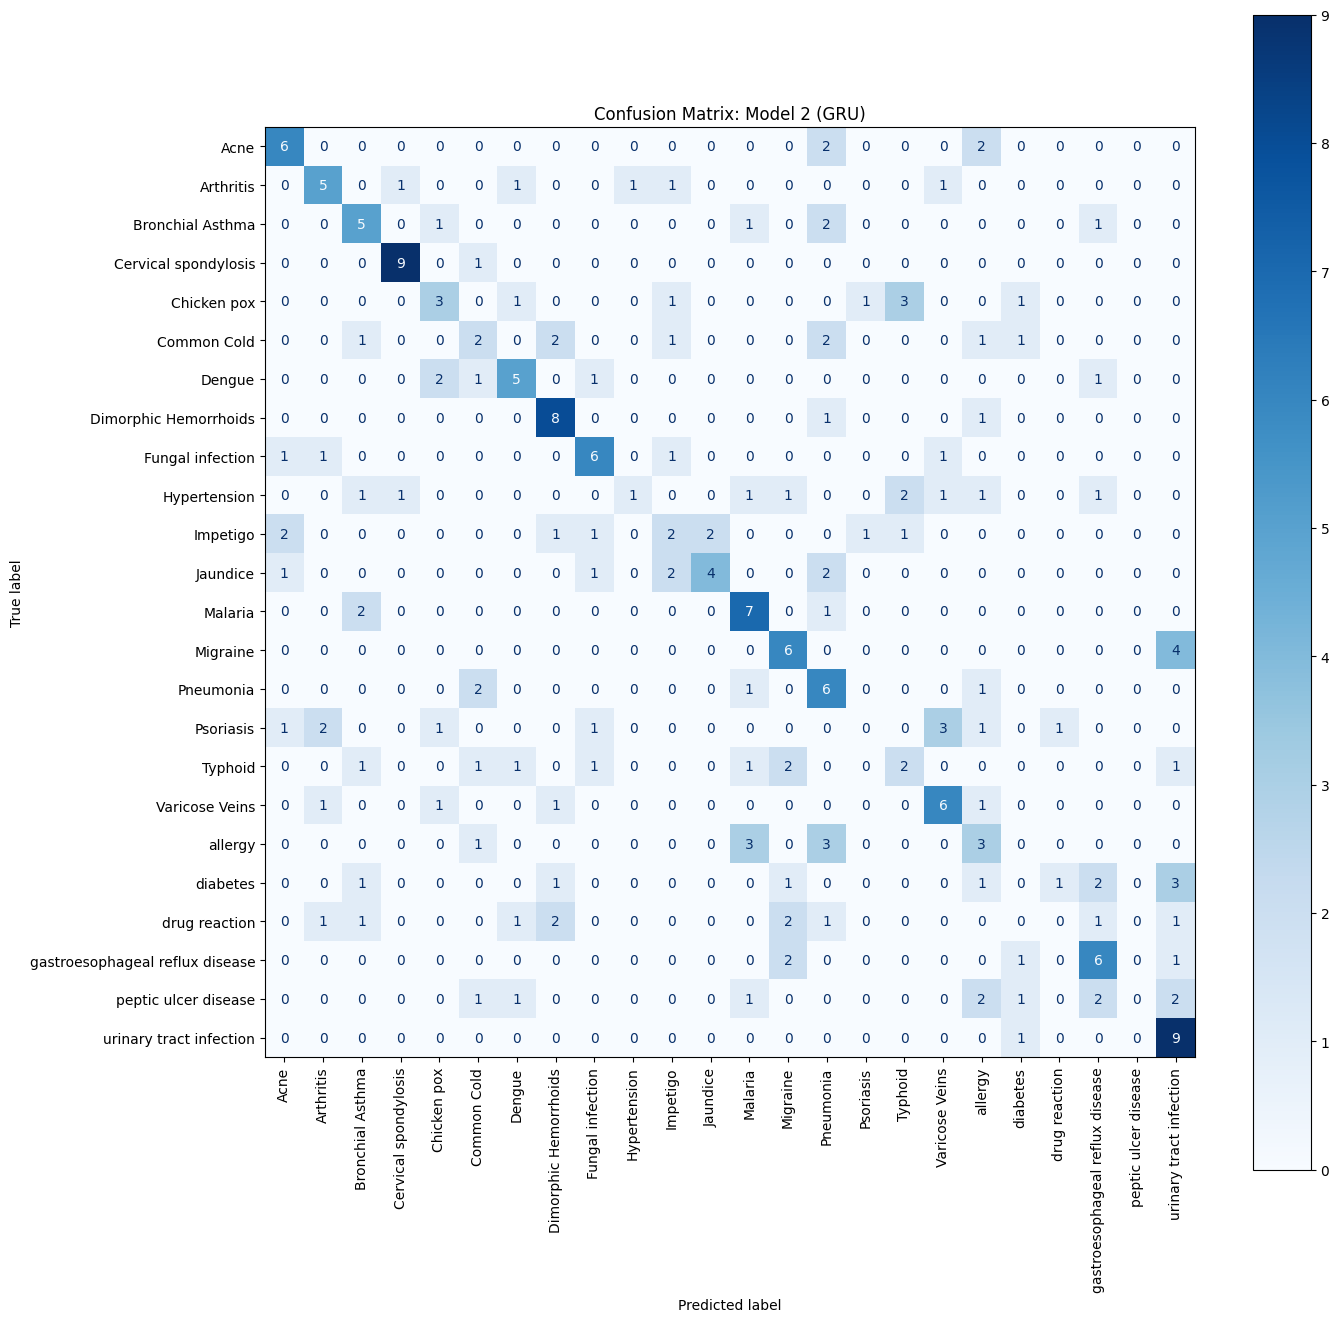

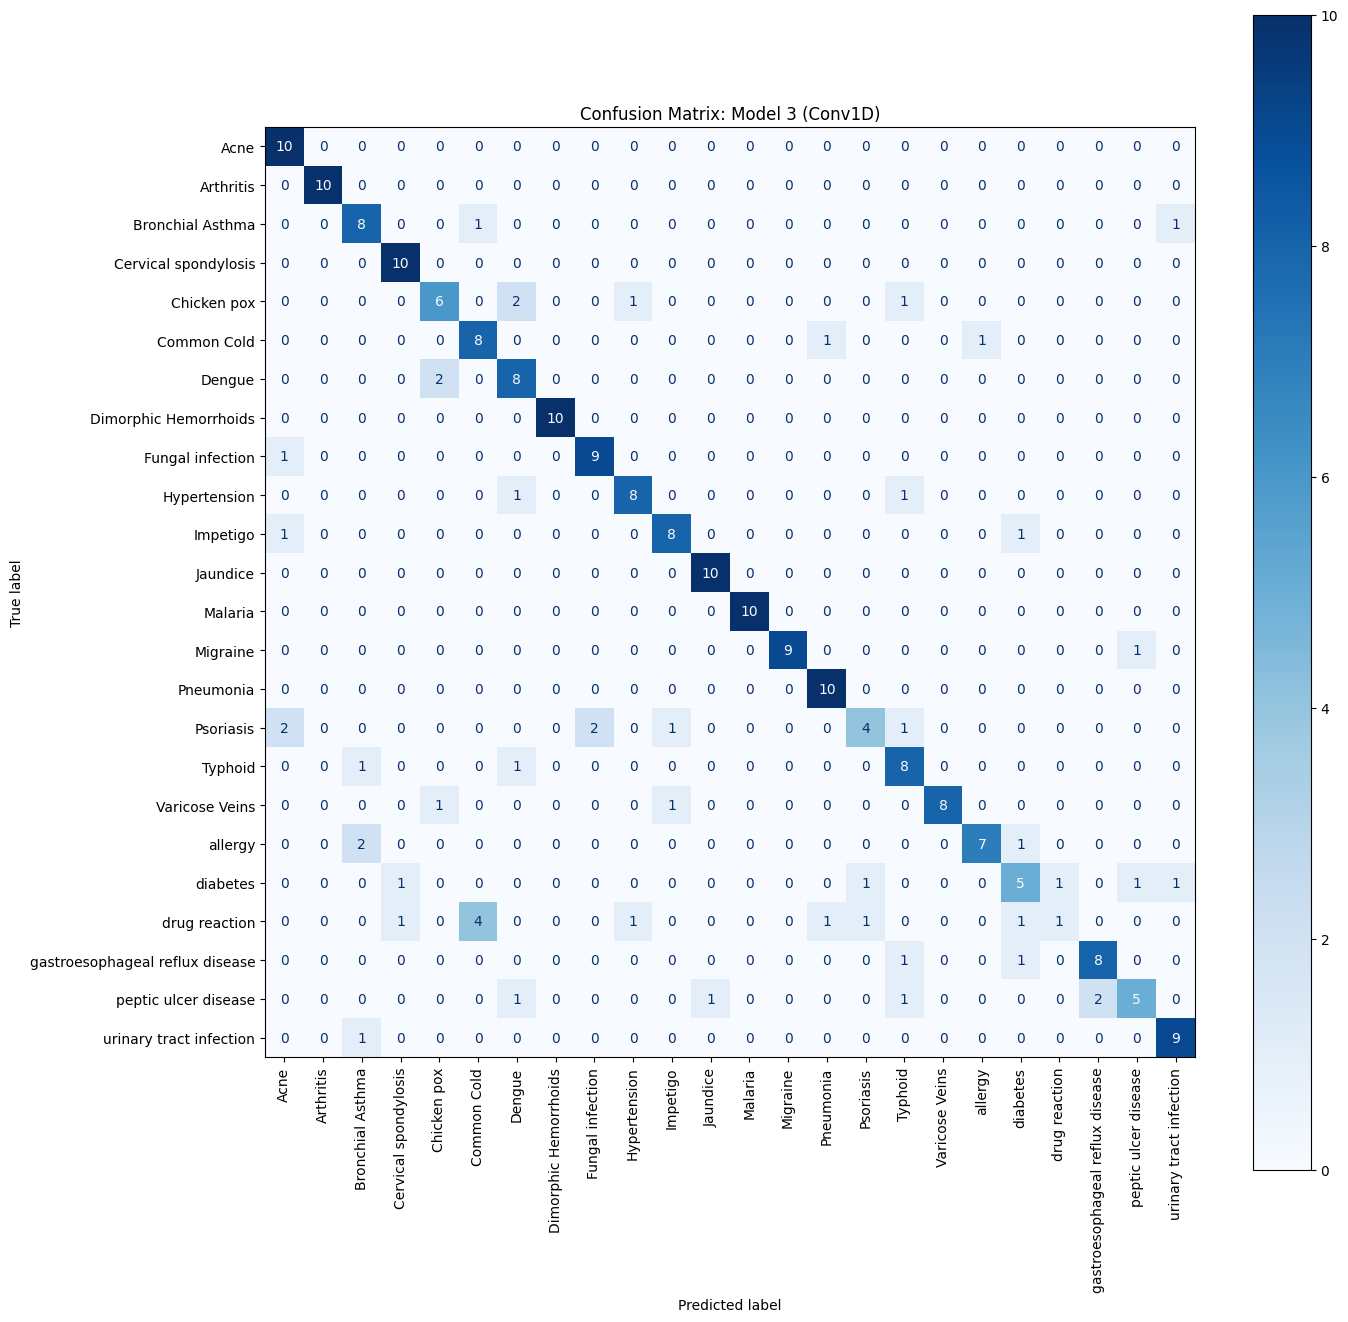

In [45]:
def plot_confusion_matrix(y_true, y_pred, title):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create the display object with disease names as labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Diseases)

    # Customize plot size to fit 24 classes
    fig, ax = plt.subplots(figsize=(15, 15))  # Adjust size as needed
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')

    plt.title(title)
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(y_test, y_pred_model_Dense_labels, 'Confusion Matrix: Model 1 (Dense)')
plot_confusion_matrix(y_test, y_pred_model_GRU_labels, 'Confusion Matrix: Model 2 (GRU)')
plot_confusion_matrix(y_test, y_pred_model_Conv1D_labels, 'Confusion Matrix: Model 3 (Conv1D)')

We will pass a symptom in natural language and make the model predict the diseas.

In [46]:
def preprocess_and_vectorize(input_text, glove_embeddings, dim=100):
    words = tokenize_remove_stopwords_lemmatize(input_text)
    
    vector = words_to_vector(words, glove_embeddings, dim)
    
    vector_reshaped = vector.reshape(1, 1, dim)  
    
    return vector_reshaped

In [53]:
def predict_disease(input_text, model, encoder):
    input_vector = preprocess_and_vectorize(input_text, glove_embeddings, dim=100)
    input_vector = input_vector.astype('float32')
    
    prediction = model.predict(input_vector)  
    
    predicted_label = np.argmax(prediction, axis=1)[0]
    
    predicted_disease = encoder.inverse_transform([predicted_label])[0]
    
    return predicted_disease

In [142]:
input_string = "I regularly experience these intense urges and the want to urinate. I frequently feel drowsy and loose focus"

cleaned_input = tokenize_remove_stopwords_lemmatize(input_string)
print(cleaned_input)

['regularly', 'experience', 'intense', 'urge', 'want', 'urinate.', 'frequently', 'feel', 'drowsy', 'loose', 'focus']


In [143]:
vector_input = words_to_vector(cleaned_input,glove_embeddings)
print(vector_input)

[-0.36537701  0.1466474   0.11705425 -0.07461091 -0.07389418  0.33428364
 -0.39343364  0.17718573 -0.01467545 -0.20355855 -0.21896436 -0.20401582
  0.34303464 -0.06955    -0.14828219 -0.012876   -0.20106991 -0.01989946
 -0.319123    0.16374845  0.19119764  0.09900882 -0.01371553 -0.24047421
 -0.17417818  0.14081182 -0.17899373 -0.13594491  0.37065545 -0.05689527
 -0.081506    0.41813545 -0.22509336 -0.04904984  0.07271364  0.11110873
  0.12597873 -0.05743363  0.11828873  0.05526454 -0.40883545 -0.14589582
  0.02144209 -0.16652024 -0.20543855 -0.11417836  0.13823527  0.05383609
  0.24833545 -0.77767181 -0.08538928 -0.10393636 -0.13110056  0.62172636
  0.27251583 -1.43136275  0.22845545 -0.09369991  0.89162091  0.16140455
  0.08943373  0.68098545 -0.29853727 -0.26130736  0.49316545  0.09558691
  0.32773727 -0.11556953  0.06119273 -0.13763182  0.08003545 -0.37188637
 -0.00957436 -0.15446373 -0.13156509  0.11849809 -0.12697909 -0.16216673
 -0.24821336 -0.21517354  0.22095309 -0.03336712 -0

In [144]:
vector_input.shape

(100,)

In [145]:
vector_input_reshaped = vector_input.reshape(1,20,5)

In [146]:
vector_input_reshaped.shape

(1, 20, 5)

In [147]:
prediction_input = model_Conv1D.predict(vector_input_reshaped)  # Shape: (1, 24)
print(prediction_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[8.78183710e-05 1.23080695e-02 4.37940145e-03 1.45638105e-05
  7.45451311e-03 4.01863083e-03 6.13996685e-02 2.21920339e-03
  3.00557143e-03 2.08068937e-02 1.44172518e-04 1.15631683e-05
  1.06882898e-03 8.25188961e-03 9.04930697e-04 4.40796791e-03
  1.56085445e-02 1.05217252e-04 6.23765402e-03 4.82023031e-01
  1.66041061e-01 3.20163965e-02 9.69045982e-02 7.05798790e-02]]


In [148]:
predicted_label = np.argmax(prediction_input, axis=1)[0]
print(predicted_label)    
    

19


In [149]:
predicted_disease = encoder.inverse_transform([predicted_label])[0]
print(f"You are likely to have : {predicted_disease}")

You are likely to have : diabetes


## Conclusion ##  

In conclusion, the Symp2Doc project demonstrated the potential of deep learning for disease prediction from natural language symptom descriptions. We learned that different neural architectures handle the data uniquely—Conv1D excelled by effectively capturing local patterns, while GRU struggled with short sequences. The Dense Neural Network performed well, but lacked the nuanced pattern extraction of Conv1D. Preprocessing with GloVe embeddings was critical in converting symptom text into meaningful vectors, ensuring accurate predictions. However, some challenges included GRU's underperformance and handling input variability across samples. Future improvements could involve using more advanced embeddings like BERT and incorporating more diverse medical datasets to enhance model generalization. Additionally, further hyperparameter tuning and ensemble methods could boost overall accuracy. This project showcases the potential of AI to complement healthcare by providing quick, data-driven insights into patient symptoms.